## The Autoregressive Conditional Heteroskedasticity Model (ARCH)

## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
sns.set()

## Loading the Data

In [2]:
raw_csv_data = pd.read_csv('../input/Index2018.csv')
raw_csv_data

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.900000,2224.95,3445.980000,18124.01
1,10/01/1994,475.270000,2225.00,3440.580000,18443.44
2,11/01/1994,474.130000,2228.10,3413.770000,18485.25
3,12/01/1994,474.170000,2182.06,3372.020000,18793.88
4,13/01/1994,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...,...
6264,23/01/2018,2839.130362,13559.60,7731.827774,24124.15
6265,24/01/2018,2837.544008,13414.74,7643.428966,23940.78
6266,25/01/2018,2839.253031,13298.36,7615.839954,23669.49
6267,26/01/2018,2872.867839,13340.17,7665.541292,23631.88


In [3]:
df_comp = raw_csv_data.copy()

## Preprocessing the Data

In [4]:
df_comp.date = pd.to_datetime(df_comp.date, dayfirst= True)
df_comp.set_index('date', inplace = True)
df_comp = df_comp.drop(['spx', 'dax', 'nikkei'], axis = 1)
df_comp

,ftse
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


In [5]:
df_comp['market_value'] = df_comp.ftse
del df_comp['ftse']

In [6]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')
df_comp

,market_value
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


## Splitting the Data

In [7]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [8]:
df.tail()

,market_value
date,
2013-04-01,6411.74
2013-04-02,6490.66
2013-04-03,6420.28
2013-04-04,6344.11
2013-04-05,6249.77


In [9]:
df_test.head()

,market_value
date,
2013-04-08,6276.94
2013-04-09,6313.20
2013-04-10,6387.37
2013-04-11,6416.14
2013-04-12,6384.39


## LLR Test Function

In [10]:
from scipy.stats.distributions import chi2

In [11]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

## Augmented Dickey-Fuller Test

In [12]:
import statsmodels.tsa.stattools as sts

In [13]:
sts.adfuller(df.market_value)

(-1.904155141883687,
 0.330108932770283,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

### From the DF test we see that the market value prices for FTSE100 belong to a Non-Stationery Source, hence it is a better option to Extract the "Returns", check for stationarity and then work on them

## Computing and Storing Returns

In [14]:
df['returns'] = df.market_value.pct_change(1).mul(100)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Computing and Storing Squared Returns

In [15]:
df['sq_returns'] = df.returns.mul(df.returns)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Returns v/s Squared returns

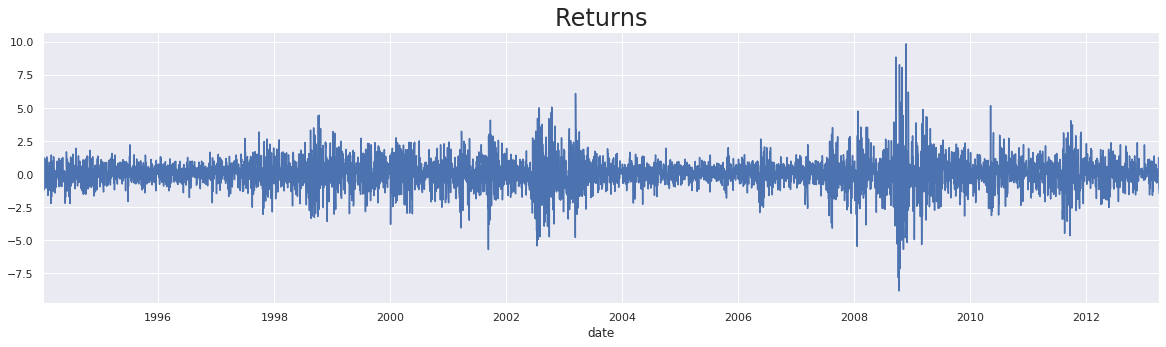

In [16]:
df.returns.plot(figsize = (20,5))
plt.title("Returns", size = 24)
plt.show()

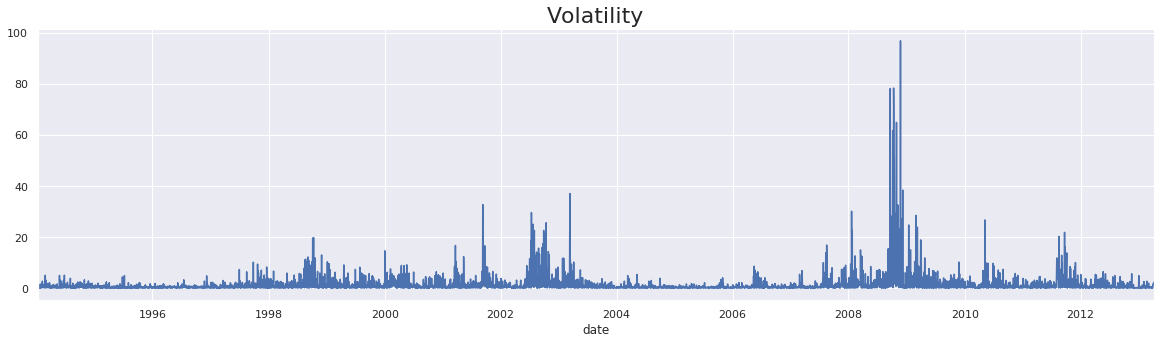

In [17]:
df.sq_returns.plot(figsize = (20,5))
plt.title("Volatility", size = 22)
plt.show()

## PACF

In [18]:
import statsmodels.graphics.tsaplots as sgt

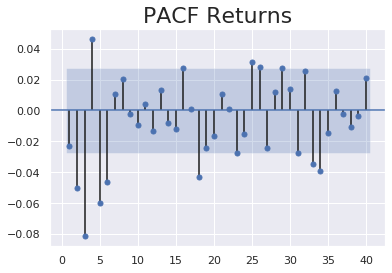

In [19]:
sgt.plot_pacf(df.returns[1:], lags = 40, zero = False, method = ('ols'))
plt.title('PACF Returns', size = 22)
plt.show()

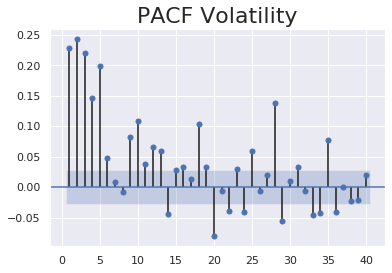

In [20]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, zero = False, method = ('ols'))
plt.title("PACF Volatility", size = 22)
plt.show()

### From the PACF for Volatility we can see that the first 6 cofficients are significant with the first 5 yeilding between 0.15 and 0.25

### Such High significant values of partal autocorrelation among the first few lags suggests that there tend to be short term trends in variance

### Another way of looking at it would be clustering. This suggests that there are periods of High Variation followed by periods of High Variation; Similarly,  there are periods of Low Variation followed by periods ofd Low Variation

## The arch_model() Method

In [21]:
!pip install arch -U

     |████████████████████████████████| 805 kB 4.8 MB/s 


In [22]:
from arch import arch_model

In [23]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734736835859
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088042271316
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189893
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Thu, Apr 30 2020   Df Residuals:                     5016
Time:                        13:51:01   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

## The Simple ARCH(1) Model

In [24]:
model_arch_1 = arch_model(df.returns[1:], 
                          mean = "Constant",
                          vol = "ARCH",
                          p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()


Iteration:      5,   Func. Count:     34,   Neg. LLF: 7660.088789377838
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Thu, Apr 30 2020   Df Residuals:                     5017
Time:                        13:51:01   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

## Higher Lag ARCH Models

## ARCH(2)

In [25]:
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7449.870533644225
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Thu, Apr 30 2020   Df Residuals:                     5016
Time:                        13:51:01   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

## ARCH(3)

In [26]:
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     45,   Neg. LLF: 7278.805807411393
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7277.050453152619
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Thu, Apr 30 2020   Df Residuals:                     5015
Time:                        13:51:02   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""

# The Generalized Autoregressive Conditional Heteroskedasticity Model (GARCH Model)

In [27]:
from arch import arch_model

## Simple GARCH(1,1) Model

In [28]:
model_garch_1_1 = arch_model(df.returns[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_1_1 = model_garch_1_1.fit(update_freq = 5)
results_garch_1_1.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734736835859
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088042271316
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189893
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Thu, Apr 30 2020   Df Residuals:                     5016
Time:                        13:51:02   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

### We do not need to fit higher order GARCH models as the GARCH(1,1) model has been mathematically proven to be the best fit for market returns. Higher order GARCH models in this case will result in Non-Significant Variables